In [3]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2023-11-14 08:09:16--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.1’

ratings_train.txt.1 100%[===================>]  13.95M  --.-KB/s    in 0.1s    

2023-11-14 08:09:16 (104 MB/s) - ‘ratings_train.txt.1’ saved [14628807/14628807]

--2023-11-14 08:09:17--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Sa

In [4]:
! pip install Korpora sentencepiece einops wandb torch-summary -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Korpora import Korpora
import pandas as pd
from pprint import pprint
# from konlpy.tag import Mecab
from nltk.tokenize import word_tokenize as en_tokenizer
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os

In [6]:
VOCAB_SIZE = 32000 + 7
SEQ_LEN = 100
PAD_IDX = 0
# Trainig Set 모집단의 크기
TRAINSET_SIZE = 120000
# 실제로 사용할 Training Set의 크기. 이 수만큼 전체 Training Set에서 Random Sampling
TRAIN_LEN = 100000
VALID_LEN = 10000
BATCH_SIZE = 2
WANDB_SAVED_PATH = ''
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cpu


In [7]:
import wandb
import os
# if want to run in offline mode

os.environ["WANDB_API_KEY"] = "d60a4af56f6cd9cccec7d9da1dbced7960b61310"
os.environ["WANDB_MODE"] = "dryrun"
wandb.init(project="Transformer", entity="jiwon7258")
RUN_PATH = ''

In [8]:
# dataset = open_subtitles_dataset()
corpus = Korpora.load("open_subtitles", root_dir='./')


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : TRAC (https://trac.edgewall.org/)
    Repository : http://opus.nlpl.eu/OpenSubtitles-v2018.php
    References :
        - P. Lison and J. Tiedemann, 2016, OpenSubtitles2016: Extracting Large Parallel Corpora
          from Movie and TV Subtitles. In Proceedings of the 10th International Conference on
          Language Resources and Evaluation (LREC 2016)

    This is a new collection of translated movie subtitles from http://www.opensubtitles.org/.

    [[ IMPORTANT ]]
    If you use the OpenSubtitle corpus: Please, add a link to http://www.opensubtitles.org/
    to your website and to your reports and publications produced with the data!
    I promised this when I got the data from the providers of that website!

 

[open_subtitles] download en-ko.tmx.gz: 48.1MB [00:04, 11.8MB/s]                            


decompress /content/open_subtitles/en-ko.tmx.gz


In [9]:
data = pd.DataFrame([corpus.train.pairs, corpus.train.texts], index = ['src', 'trg'])
data = data.transpose()
data.to_csv('data.txt', index=False)
data.head()

,src,trg
0,"Through the snow and sleet and hail, through t...","폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘..."
1,"ever faithful, ever true, nothing stops him, h...",우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!
2,Look out for Mr Stork That persevering chap,황새 아저씨를 기다리세요
3,He'll come along and drop a bundle in your lap,찾아와 선물을 주실 거예요
4,You may be poor or rich It doesn't matter which,가난하든 부자이든 상관이 없답니다


In [10]:
with open('trg.txt', mode= 'w', encoding='utf8') as f:
    f.write('\n'.join(data['trg']))

In [11]:
corpus = "trg.txt"
prefix = "trg"
vocab_size = VOCAB_SIZE - 7
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" +  # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" +  # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" +  # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" +  # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" +  # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]")  # 사용자 정의 토큰

In [12]:
# vocab loading
vocab_file = "/content/trg.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [13]:
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

In [14]:
import json

In [15]:
prepare_train(vocab, "/content/ratings_train.txt", "/content/ratings_train.json")
prepare_train(vocab, "/content/ratings_test.txt", "/content/ratings_test.json")

# 모델 설명

In [16]:
# vocab loading
vocab_file = "/content/trg.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요.",
  "치킨 먹자"
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워요', '.']
['▁감기', '▁조심하세요', '.']
['▁치킨', '▁먹자']
torch.Size([3, 5])
tensor([[ 6234, 30574,   583,  1275, 30547],
        [11841,  9982, 30547,     0,     0],
        [ 9161,  9145,     0,     0,     0]])


In [17]:
""" configuration json을 읽어들이는 class """
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [18]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 32007, 'n_dec_vocab': 32007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


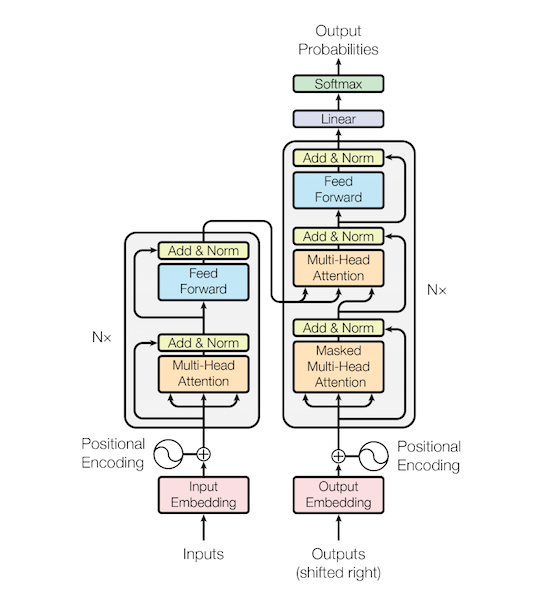

## Embedding.

그림을 보면 Embedding 부분이 inputs 이후 바로 나옴.

임베딩 ---> 토큰을 벡터로 변환시키는 거.

In [19]:
#n_seq : seq길이,위치 인코딩 테이블의 크기를 결정하는데, 이는 모델이 처리할 수 있는 최대 시퀀스 길이를 정의
#d_hidn : 각 토큰의 출럭/

In [20]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([3, 5, 128])


## positional Embedding

**Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the
tokens in the sequence**

rnn과 cnn이 아니라서 순서를 사용하기 위해서 position embedding을 사용해야 한다.

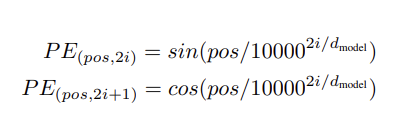

짝수번째-----> sin, 홀수번째------>cos

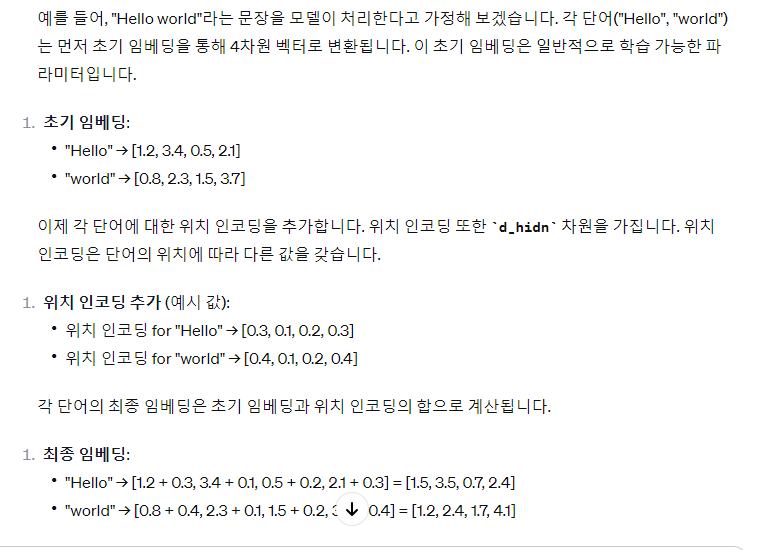

In [21]:
#n_seq : seq길이,위치 인코딩 테이블의 크기를 결정하는데, 이는 모델이 처리할 수 있는 최대 시퀀스 길이를 정의
#d_hidn : 각 토큰의 출럭/
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position,i_hidn):
    return position / np.power(10000, 2*(i_hidn//2)/d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]
    #짝수번째 인덱스를 의미
  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin, 짝수행
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos, 홀수행

  return sinusoid_table

In [22]:
#padding mask를 구하는 코드
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  #
    return pad_attn_mask

나중에 패딩 마스크와 디코더의 maksed-attention의 마스크가 더해짐

In [23]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

##  scaled-dot-product attention

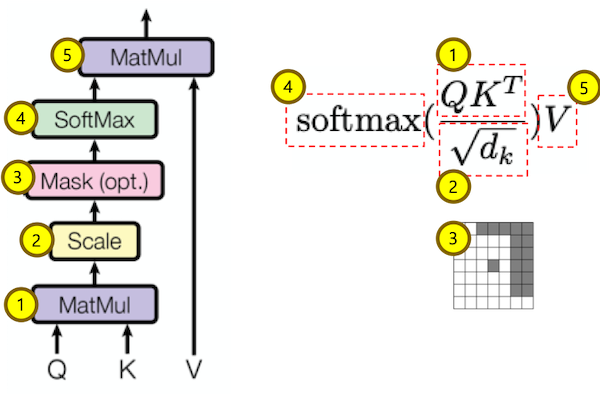

여기서 Q,K,V는 각각 현재시점에서 주목하고 있는 값, k는 시퀸스 내부의 query와 다른 요소. 그리고 인코더의 Q,K,V는 모두 입력 임베딩에서 도출된다.

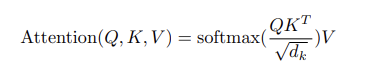

1. matmul
Q,와 K의 행렬 연산을 의미한다.

2. scale
dk의 루트로 나누어 준다.

왜 나누어 주는가? softmax의 지수 함수 특성인데 분자가 너무 커지면 y값이 너무 커지기 때문에 전체 시퀸스를 동등하게 고려하는게 아니라 하나로 편향되어 판단할 수 있게 하기 때문이다.

왜 dk? Q,K 둘다 dk차원에서 도출되기 떄문이다.

3. 마스킹을 해줌. 이건 auto-regressive 특성을 보존하기 위해서 쓰는건데, 현재 시퀸스 이후의 요소가 개입되는걸 막기 위해서 쓰는거임.

4. 그다음 K를 다시 행렬곱을 취해서 마지막 값을 리턴한다.

In [58]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(0.1)
        #이게 바로 지금 분모임
        self.scale = 1 / (64 ** 0.5)

    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        #Q와 K 전치의 행렬 연산
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        #마스킹
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        #softmax 함수 적용
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        #k와 다시 행렬연산
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

context는 입력에 대한 어텐션 가중치가 적용된 출력을 나타내며, attn_prob는 이러한 가중치(어텐션 확률)를 나타낸다.

##  Multi-Head Attention

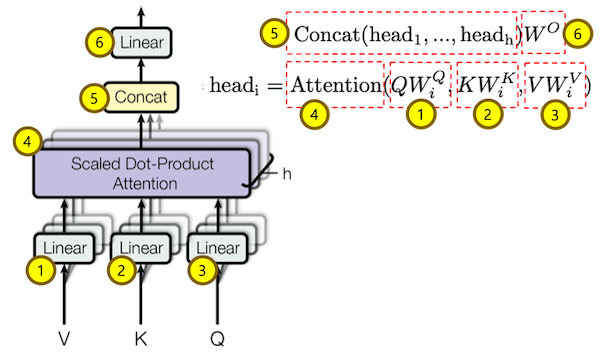

멀티 해드 어탠션이란 해드의 갯수에 따라서 어탠션을 병렬로 나누어서 계산하는 방법.

**Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel,**

각 선형으로 투영하고 병렬로 어탠션 수행

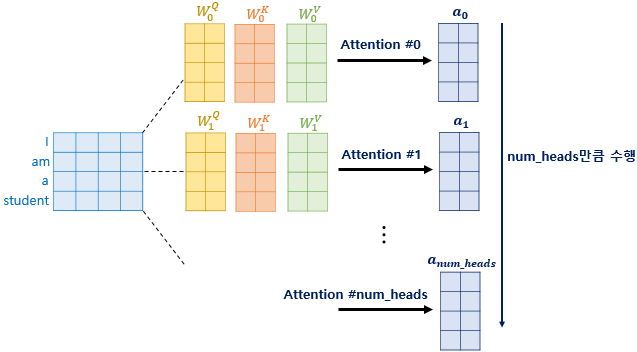

이런식으로 병렬로 수행. 그다음에는 concat로 합치고, 가중치를 곱한다.

근데 이거 코드가 중간에 보면 transpose(1,2)를 해주고 concat을 해주는데, 이걸 왜 해주는지 모르겠다.

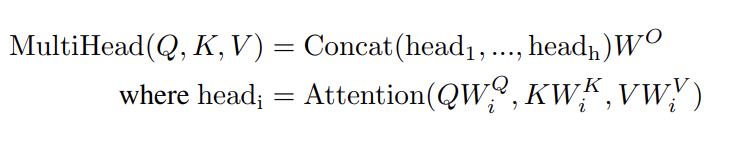

그럼 왜 멀티-어탠션을 수행할까?

1. 표현력이 더욱더 풍부해지기 떄문.

2. 정규화의 이점


In [59]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head
        #torch.nn.Linear(in_features, out_features, bias=True), 선형변환을 구현
        #입력 크기가 (batch_size, in_features)인 경우, 출력 크기는 (batch_size, out_features)가 됩니다.
        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # 각 선형 변환을 하는거
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        #scaled-dot-attn 실행
        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## FeeedForward

**Another way of describing this is as two convolutions with kernel size 1.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality df f = 2048.**

커널사이즈가 1인 2개의 합성곱으로 표현.

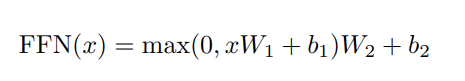

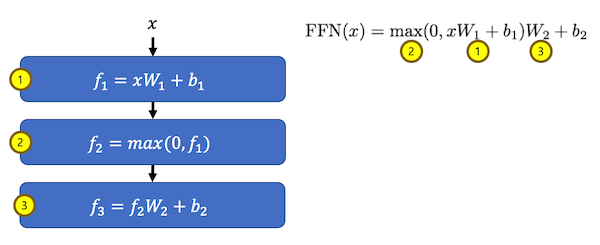

f1-----> relu------->f3

왜 relu를 사용하는가? 단순 선형 변환 2번을 진행하면 아무런 의미가 없다. 비선형성을 추가해서 표현력을 높이기 위해 relu를 사용하는거임.

In [60]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

# 인코더

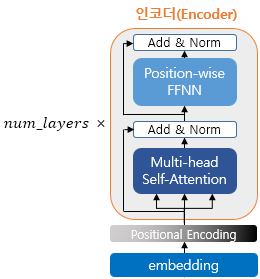

**The encoder is composed of a stack of N = 6 identical layers. Each layer has two sub-layers.**

인코더는 6개의 층으로 구성되어 있다. 그리고 각 층은 2개의 서브레이어로 구성되어 있다.

**We employ a residual connection [11] around each of
the two sub-layers, followed by layer normalization**

잔차연결을 통해서 연결되어 있다.

In [61]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        #멀티해드어탠션
        self.self_attn = MultiHeadAttention(n_head=self.config.n_head, d_head=self.config.d_head,d_hidn=self.config.d_hidn)
        #정규화
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        #POSITION-WISE
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        #정규화
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        #멀티해드어탠션
        #출력 : att_outputs 입력에 대한 어텐션 가중치가 적용된 출력을 나타내며, attn_prob는 이러한 가중치(어텐션 확률)를 나타낸다.
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        #정규화로 보냄. inputs + att_outputs는 잔차 연결을 의미. 그림의 ADD 부분
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        #정규화로 보낸 값에 POSITION-WISE
        ffn_outputs = self.pos_ffn(att_outputs)
        #이걸 다시 정규화. ffn_outputs + att_outputs는 잔차 연결을 의미. 그림의 ADD 부분
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        #ffn_outputs는 출력 값이고, attn_prob는 확률값
        return ffn_outputs, attn_prob

In [62]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        #임베딩 + POSITIONAL-EMBEDDING
        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        #MODULELIST로 층을 만들기
        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])

    def forward(self, inputs):
      #inputs.size(1): 입력텐서의 시퀀스 길이
      #arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype) 해당 위치에 대해서 숫자를 부여
      #expand(inputs.size(0), inputs.size(1)) : 각 배치의 정보를 할당한다고 생각하면 편함.
      #contiguous() + 1시작을 0이 아닌 1부터 시작하려고
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
      #inputs.eq는 PyTorch에서 제공하는 메서드로, 텐서 내의 각 요소가 특정 값과 같은지(equal) 여부를 확인하는 데 사용됩니다. 즉 패딩값을 찾을려고
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        #임베딩 + posion-embedding
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        # "Scaled Dot-Product Attention"에서 사용되는 마스크를 생성
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs



```
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
```

설명

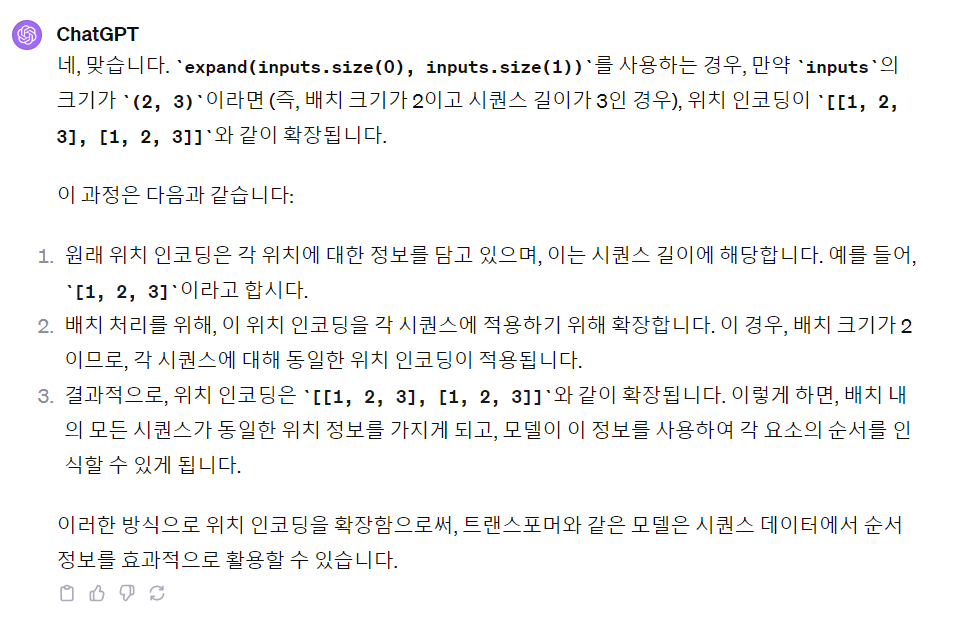

#디코더

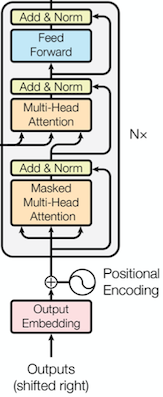

In [63]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(n_head=self.config.n_head, d_head=self.config.d_head,d_hidn=self.config.d_hidn)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(n_head=self.config.n_head, d_head=self.config.d_head,d_hidn=self.config.d_hidn)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        #잔차연결
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob


In [64]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        #임베딩 + POSITIONAL-EMBEDDING
        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
      #inputs.size(1): 입력텐서의 시퀀스 길이
      #arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype) 해당 위치에 대해서 숫자를 부여
      #expand(inputs.size(0), inputs.size(1)) : 각 배치의 정보를 할당한다고 생각하면 편함.
      #contiguous() + 1시작을 0이 아닌 1부터 시작하려고
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_dec_seq, d_hidn)
        #임베딩 + posion-embedding
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        #masked-attn
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

#transformer model

In [65]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)

    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs


In [66]:
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)

    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        #torch.max는 최대값과 그 위치(인덱스)를 반환합니다. 여기서 _는 최대값의 위치를 받지만, 이후에 사용되지 않음을 나타냅니다
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        #dec_outputs와 self.config.d_hidn는 동일한 차원을 가져야 한다.
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs


In [67]:
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])

    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)

    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [68]:
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

In [69]:
batch_size = 128
train_dataset = MovieDataSet(vocab, f"/content/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, f"/content/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading /content/ratings_test.json: 100%|██████████| 49997/49997 [00:02<00:00, 19700.10 lines/s]


In [70]:
from tqdm import tqdm, tqdm_notebook, trange

In [71]:
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [72]:
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [75]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 32007, 'n_dec_vocab': 32007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cpu'), 'n_output': 2}
